# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain`

## set seed
seed = 1337

## Custom functions
def load_fb_wall_data(df_wall_posts,lag_days):
    """
    arguments:
    df_wall_posts: pandas df
    - contains user1, user2 and unix timestamp
    
    lag_days: int
    - the lag of days to include in the nx graph
    
    returns:
    G_t: nx.Graph
    - a graph with weights within the specified time range
    """
    t0 = data.timestamp.max() - 86400 * lag_days  # Lower bound of time-slice (here: 7 days before last wall post)
    t1 = data.timestamp.max()                     # Upper bound of time-slice

    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.Graph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    
    return G_t    

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

#### Answer to Ex 10.1.1.:
*I would generate 1000 random networks that preserves the degree sequence. For each random network I would calculate the network diameter ($<d>=\frac{ln(N)}{ln(<k>)}$) and evaluate whether the random network had smaller (or bigger depending on the null hypothesis) network diameter than the network I was evaluating. The p-value would then be the share of random networks with smaller (or bigger) diameter.*

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

#### Answer to Ex 10.1.2.:
*the double_edge_swap removes to randomly chosen edges and creates new edges. If either of the new generated edges already exist no swap is performed and another attempt is made to find a suitable edge pair. The parameter nswap determines how many edges should be 're-shuffled' in the network. The parameter max_tries limits the number of attempts to re-shuffle. If the method is able to succesfully generate a swap before max_tries attempts, it will return the swapped edges. Hence, max_tries is only a upper bound on the number of attempts. Because each attempt is random and maintains the same number of degrees, the degree distribution will remain unchanged after the swap.*

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

The ALCC of Facebook Wall posts within the past 7 days is: 0.01838401670026459
The average ALCC of Facebook Wall posts within the past 7 days over 1000 iterations with double_edge_swap is: 0.00916144297032151
The null hypothesis is that the ALLC in the fb network is the same as in a null network.
The alternative hypothesis is that the ALLC is larger than the null network.
The p-value is:0.0


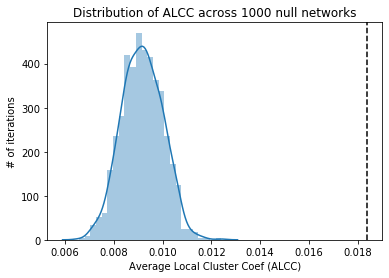

In [20]:
## Load data
data = pd.read_csv(
    "facebook-wall.txt.gz",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)


# create network
lag_days = 7
G        = load_fb_wall_data(data,lag_days=lag_days)

## Calculate average local cluster coefs (alcc) with weights
G_ALCC  = nx.average_clustering(G)
print(f'The ALCC of Facebook Wall posts within the past {lag_days} days is: {G_ALCC}')

## Iterations with double swaps
n_iter      = 1000
nswap       = 1000
max_tries   = 10000
ALLC_values = []
for i in range(n_iter):
    G_tmp = G.copy()
    nx.double_edge_swap(G_tmp,nswap=nswap,max_tries=max_tries,seed=seed+i)
    G_tmp_ALLC = nx.average_clustering(G_tmp)
    ALLC_values.append(G_tmp_ALLC)
    del G_tmp
print(f'The average ALCC of Facebook Wall posts within the past {lag_days} days over {n_iter} iterations with double_edge_swap is: {np.mean(ALLC_values)}')


## Calculate p-test
df_null_test = pd.DataFrame({'ALLC_null_model':ALLC_values,'ALLC_fb':G_ALCC})\
.assign(null_test = lambda df:(df.ALLC_null_model<=df.ALLC_fb).astype(int))

p_value = 1 - df_null_test.null_test.mean()
print(f'The null hypothesis is that the ALLC in the fb network is the same as in a null network.\nThe alternative hypothesis is that the ALLC is larger than the null network.\nThe p-value is:{p_value}')

## Create histogram
fig,ax = plt.subplots()
sns.distplot(df_null_test.ALLC_null_model,ax=ax)
ax.axvline(x=G_ALCC,color='Black',linestyle="--")
ax.set_xlabel('Average Local Cluster Coef (ALCC)')
ax.set_ylabel('# of iterations')
ax.set_title(f'Distribution of ALCC across {n_iter} null networks')
plt.show()

#### Text answer to Ex. 10.1.3.:
*According to my findings the ALCC is significantly larger in the real FB data than a random (null) network. Intuitively this makes very good sense - plenty of properties about a real social network would imply that the network is not random. For example, if we only form connections with the people we befriend, the preferences of friendsship is going to shape the network.*

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


#### Answer to Ex. 10.2.1.:

1. i and j refers to edges between node i and node j. $A_{ij}$ is the edge weight (binary if it is unweighted graph) between node i and j.  

2. The $\delta$ function is used to only calculate modularity of nodes within the same cluster (community). There would be several ways to implement the $\delta$ function in code. It would probably be a good idea to code up Louvain Modularity as a matrix computation (matrix computations are much more efficient than sum loops) and then let the $\delta$ be a binary matrix.

3. Basically the null model reflects the expected degree for node i and j. Hence, if the expected degrees is larger (smaller) than the actual links between i and j, the two nodes are less (more) likely to be in the same cluster. 

4. By incorporating the $\delta$ one can calculate the modularity under different clusters - and hereby find the set of clusters that maximizes the modularity in the network. 

5. Because an undirected graph has two nodes per link (edge).

6. Q represents the average modularity in a graph under a specific set of clusters. The modularity is an expression of how 'tight' two nodes in the same cluster are connected compared to the expected degrees in the network. If two nodes have very low modularity one can increase Q by letting the two nodes be in different clusters.

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [63]:
import numpy as np
import networkx as nx

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network. I've applied a nested loop,
    which is fine for small networks. It would be better to compute it with matrices in the case of larger networks.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    
    G       = nx.from_numpy_matrix(A)
    m       = G.number_of_edges()
    degrees = [d for n,d in G.degree]
    nodes   = [n for n,d in G.degree]
    Q       = 0
    
    for i in nodes:
        cluster_i = c[i]
        k_i       = degrees[i]
        for j in nodes:
            cluster_j = c[j]
            k_j       = degrees[j]
            A_ij      = int(i in G.neighbors(j))
            if cluster_j==cluster_i:
                modularity = A_ij - ((k_i*k_j)/(2*m))
            else:
                modularity = 0
            Q += modularity
    Q = Q /(2*m)
            
    return Q

In [64]:
print(f'The modularity of A and c is: {modularity(A,c)}')

The modularity of A and c is: 0.12244897959183675


> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

The best cluster combination according to Louvian modularity is: (0, 0, 0, 1, 1, 1) with modularity 0.3571428571428571


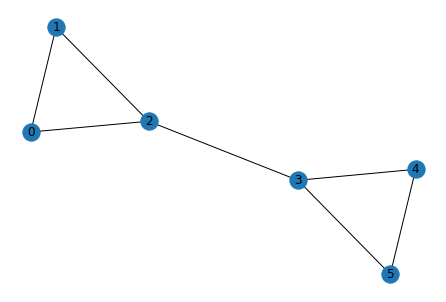

In [87]:
import itertools

# Make every possible combination of clusters. Silly solution, but works fine for this tiny network.
c_combinations    = list(itertools.product(*[range(5)]*6))
modularity_values = []
for c in c_combinations:
    Q = modularity(A,c)
    modularity_values.append(Q)

best_combination = c_combinations[modularity_values.index(np.max(modularity_values))]
print(f'The best cluster combination according to Louvian modularity is: {best_combination} with modularity {np.max(modularity_values)}')

## Draw graph to visualize this is indeed the best option
G       = nx.from_numpy_matrix(A)
nx.draw(G,with_labels=True)

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

In [142]:
import random

def louvian_method(A):
    """
    the louvian method seek to find the best community separation (highest modularity) using the follwoing steps
    
    1: Set community to be its own community (c_init)
    2: Compute the modularity for c_init
    3: Pick a random node and give every neighbor its own cluser label. If re-labeling increase modularity, then maintain re-labeling.
    4: Repeat step 2 and 3 until modularity ceases to increase for any re-labeling
    
    Inputs:
    A: numpy array
    - The adjacency matrix
    
    Output:
    c_best: list
    - The community with the highest modularity    
    """
     
    G                 = nx.from_numpy_matrix(A)
    c                 = list(range(len(A)))
    continue_louvian_method = True
    while continue_louvian_method:
        Q                 = modularity(A,c)
        random_node       = random.randint(0,len(A)-1)
        random_node_label = c[random_node]
        neighbours        = list(G.neighbors(random_node))
        Q_loop            = []
        c_loop            = []

        for neighbour in neighbours:
            c_tmp              = c
            c_tmp[neighbour]   = random_node_label
            Q_tmp              = modularity(A,c)
            Q_loop.append(Q_tmp)
            c_loop.append(c_tmp)

        if np.max(Q_tmp)>Q:
            continue_louvian_method = True
            c                       = c_loop[Q_loop.index(np.max(Q_tmp))]
        else:
            continue_louvian_method = False
    
    return c
louvian_method(A)

[0, 0, 0, 4, 4, 4]

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

The number of communities in FB network is: 2041. The average size of community is: 3.289563939245468


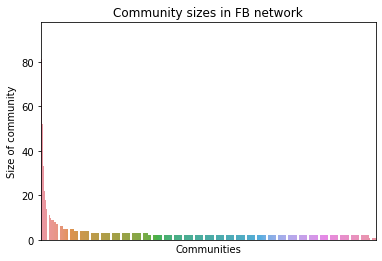

In [183]:
G_fb         = load_fb_wall_data(df_wall_posts=data,lag_days=4)
erase_nodes  = [n for n,d in G_fb.degree() if d<1]
G_fb.remove_nodes_from(erase_nodes)
best_partition = community.best_partition(G_fb)
df_plot        = pd.DataFrame({'node_id':[node for node,community in best_partition.items()],
                             'community_id':[community for node,community in best_partition.items()]}
                             )

print(f"The number of communities in FB network is: {df_plot.community_id.unique().shape[0]}. The average size of community is: {df_plot['community_id'].value_counts().values.mean()}")

fig,ax = plt.subplots()
sns.countplot(x='community_id',data=df_plot,order=df_plot['community_id'].value_counts().index,ax=ax)
ax.get_xaxis().set_ticks([])
ax.set_xlabel('Communities')
ax.set_ylabel('Size of community')
ax.set_title('Community sizes in FB network')
plt.show()

#### Text answer to Ex 10.2.4:
*The distribution of communities reveal that the FB wall post network has a sparse distribution of communities. That is, we have a few communities which are very large. The remaining communities are fairly small with around 3 people in each community.*

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

In [186]:
import netwulf as nw

## Add lovian partionin to facebook graph
nx.set_node_attributes(G_fb,best_partition,'group')
nw.visualize(G_fb)

(None, None)

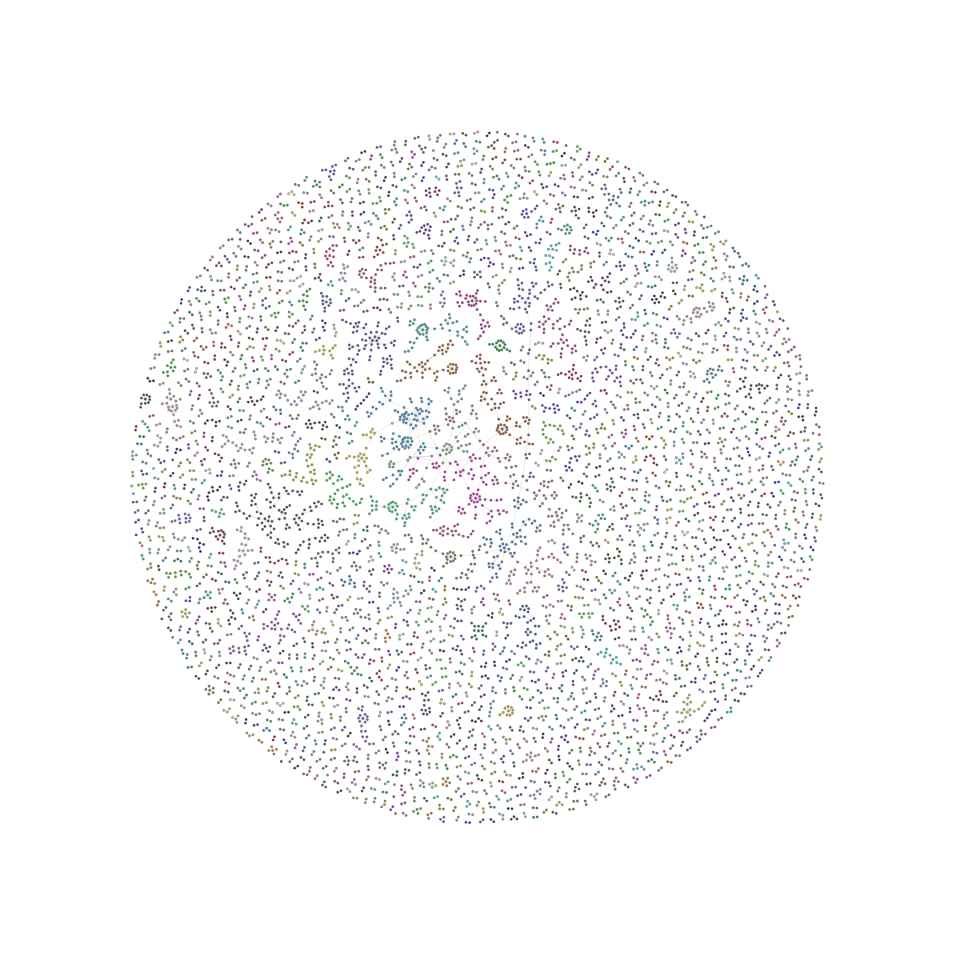

In [188]:
from IPython.display import Image
Image("fb_wall_post_network.png")

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

#### Answer to Ex 10.2.6:
*I don't think my partioning of communities in the facebook data is horrible? It's a little hard to explain a problem that I don't directly observe in my network. I'll wait and see the solution to the exercise to understand what kind of problem I was suppose to see in the network.*

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*